In [1]:
import os
os.chdir('../')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from dateutil.relativedelta import relativedelta
pd.set_option('display.max_columns', None)
import seaborn as sns

In [3]:
indir = Path('drive/output/derived/project_outcomes')

In [4]:
time_period = 6
rolling_window = 732
criteria_col = 'commits'
criteria_pct = 75
consecutive_periods = 3
post_periods = 2
threshold_stat = 0

In [15]:
df_departed = pd.read_parquet(f'drive/output/derived/contributor_stats/departed_contributors/departed_contributors_major_months{time_period}_window{rolling_window}D_criteria_{criteria_col}_{criteria_pct}pct_consecutive{consecutive_periods}_post_period{post_periods}_threshold_gap_qty_{threshold_stat}.parquet')
contribution_histories = pd.read_parquet(f'drive/output/derived/contributor_stats/contributor_data/major_contributors_major_months{time_period}_window{rolling_window}D_samplefull.parquet')

df_pct = contribution_histories[['repo_name','time_period'] + criteria_pct_cols].drop_duplicates(subset = ['repo_name','time_period'])\
    .sort_values(['repo_name','time_period'])
departed_col_ordering = df_departed.columns

df_departed = pd.merge(df_departed, df_pct, how = 'left')[departed_col_ordering]


In [17]:
df_departed['diff'] = df_departed.groupby(['repo_name','actor_id'])['consecutive_periods'].transform('diff')
df_departed = pd.merge(df_departed, df_departed.query('diff>1')[['repo_name','actor_id']].assign(drop = 1),
         how = 'left').query('drop.isna()')

In [18]:
time_periods = df_departed['time_period'].sort_values().unique().tolist()

In [19]:
df_bal = df_departed[['repo_name','actor_id']].drop_duplicates()
df_bal['time_period'] = [time_periods for i in range(df_bal.shape[0])]
df_bal = df_bal.explode('time_period')

In [20]:
df_departed['first_period'] = df_departed.groupby(['repo_name','actor_id'])['time_period'].transform('min')
df_full = pd.merge(df_bal, df_departed, how = 'left')
ffill_cols = ['first_period','total_consecutive_periods','final_period']
df_full[ffill_cols] = df_full.groupby(['repo_name','actor_id'])[ffill_cols].ffill()
df_full = df_full.query('time_period >= first_period')
df_full['grouped_index'] = df_full.groupby(['repo_name','actor_id'])['time_period'].transform('cumcount')

df_full = pd.merge(
    df_full,
    df_full.query('time_period == final_period')\
        [['repo_name','actor_id','grouped_index']].rename({'grouped_index':'final_index'}, axis = 1))
df_full['final_index'] = df_full.drop('final_period', axis = 1).apply(
    lambda x: x['final_index'] if x['below_qty_mean_gap0'] == 1 else x['final_index']+1, axis = 1)
df_full = pd.merge(df_full.drop('final_period', axis = 1), df_full.query('grouped_index == final_index')[['actor_id','repo_name','time_period']]\
                      .rename({'time_period':'final_period'}, axis = 1))
df_full['first_post_period_index'] = df_full['final_index'] + 1
df_full['relative_time'] = (df_full['grouped_index'] - df_full['final_index'])-1

In [21]:
"""all_preperiods_mean = df_full.query('time_period <= final_period')\
    .groupby(['repo_name','actor_id'])[criteria_col].mean()
all_consecutive_preperiods_mean = df_full.query('time_period <= final_period & (final_index - total_consecutive_periods) < grouped_index')\
    .groupby(['repo_name','actor_id'])[criteria_col].mean()
consecutive_preperiods_mean = df_full.query(f'time_period <= final_period & (final_index - {consecutive_periods}) < grouped_index')\
    .groupby(['repo_name','actor_id'])[criteria_col].mean()
all_postperiods_mean = df_full.query('time_period > final_period')\
    .groupby(['repo_name','actor_id'])[criteria_col].mean()
consecutive_postperiods_mean = df_full.query(f'time_period > final_period & (grouped_index - final_index) <= {post_periods}')\
    .groupby(['repo_name','actor_id'])[criteria_col].mean()


df_all_pre = all_preperiods_mean.reset_index().rename({criteria_col: f'all_pre_{criteria_col}'}, axis = 1)
df_all_consecutive = all_consecutive_preperiods_mean.reset_index().rename({criteria_col: f'all_consecutive_pre_{criteria_col}'}, axis = 1)
df_consecutive_pre = consecutive_preperiods_mean.reset_index().rename({criteria_col: f'consecutive_pre_{criteria_col}'}, axis = 1)
df_all_post = all_postperiods_mean.reset_index().rename({criteria_col: f'all_post_{criteria_col}'}, axis = 1)
df_consecutive_post = consecutive_postperiods_mean.reset_index().rename({criteria_col: f'consecutive_post_{criteria_col}'}, axis = 1)

df_full = df_full.merge(df_all_pre).merge(df_all_consecutive).merge(df_consecutive_pre)
df_full[criteria_col] = df_full[criteria_col].fillna(0)"""

"all_preperiods_mean = df_full.query('time_period <= final_period')    .groupby(['repo_name','actor_id'])[criteria_col].mean()\nall_consecutive_preperiods_mean = df_full.query('time_period <= final_period & (final_index - total_consecutive_periods) < grouped_index')    .groupby(['repo_name','actor_id'])[criteria_col].mean()\nconsecutive_preperiods_mean = df_full.query(f'time_period <= final_period & (final_index - {consecutive_periods}) < grouped_index')    .groupby(['repo_name','actor_id'])[criteria_col].mean()\nall_postperiods_mean = df_full.query('time_period > final_period')    .groupby(['repo_name','actor_id'])[criteria_col].mean()\nconsecutive_postperiods_mean = df_full.query(f'time_period > final_period & (grouped_index - final_index) <= {post_periods}')    .groupby(['repo_name','actor_id'])[criteria_col].mean()\n\n\ndf_all_pre = all_preperiods_mean.reset_index().rename({criteria_col: f'all_pre_{criteria_col}'}, axis = 1)\ndf_all_consecutive = all_consecutive_preperiods_mean.res

In [22]:
pre_period = 6
post_period = 4

def DepartureEventStudy(df_full, pre_period, post_period, criteria_col, enforce_eq_obs = False):
    all_preperiods_mean = df_full.query('time_period <= final_period')\
        .groupby(['repo_name','actor_id'])[criteria_col].mean()
    df_all_pre = all_preperiods_mean.reset_index().rename({criteria_col: f'all_pre_{criteria_col}'}, axis = 1)
    df_full = df_full.merge(df_all_pre)
    normalization_col = f'all_pre_{criteria_col}' #f'all_consecutive_pre_{criteria_col}' #f'consecutive_pre_{criteria_col}'
    df_panel = df_full[['repo_name','actor_id','time_period','relative_time',criteria_col,normalization_col]]
    df_panel['outcome'] = (df_panel[criteria_col]/df_panel[normalization_col]).fillna(0)

    df_panel = df_panel.copy()
    if enforce_eq_obs:
        df_panel['smallest_relative_time'] = df_panel.groupby(['repo_name','actor_id'])['relative_time'].transform('min')
        df_panel['largest_relative_time'] = df_panel.groupby(['repo_name','actor_id'])['relative_time'].transform('max')
        df_panel = df_panel.query(f'smallest_relative_time <= -{pre_period} & largest_relative_time >= {post_period}-1')
    
    sns.lineplot(x='relative_time', y='outcome', data=df_panel.query(f'relative_time >= -{pre_period} & relative_time < {post_period}').reset_index(), errorbar=('ci', 95))
    plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
    plt.title(f'Event Study Plot of {criteria_col} relative to departure')
    plt.show()

In [23]:
id_cols = ['user_type','repo_name','actor_id','time_period']
val_cols =[col for col in contribution_histories.columns if 'pct' not in col and col not in id_cols]
pct_cols = [col for col in contribution_histories.columns if 'pct' in col]
contribution_histories_reordered = contribution_histories[id_cols + val_cols + pct_cols]

contribution_histories_reordered[pct_cols] = \
    contribution_histories_reordered.groupby(['repo_name','time_period'])[pct_cols].transform('bfill')
contribution_histories_reordered[pct_cols] = \
    contribution_histories_reordered.groupby(['repo_name','time_period'])[pct_cols].transform('ffill')
contribution_histories_reordered['user_type'] = contribution_histories_reordered.groupby(['actor_id'])['user_type'].transform('bfill')
contribution_histories_reordered['user_type'] = contribution_histories_reordered.groupby(['actor_id'])['user_type'].transform('ffill')

In [24]:
df_departed_histories = pd.merge(df_full, contribution_histories_reordered, how = 'left')
df_departed_histories[val_cols] = df_departed_histories[val_cols].fillna(0)
df_departed_histories = df_departed_histories.query('user_type != "Bot"')

/tmp/user/20506/ipykernel_2538725/3767982912.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_panel['outcome'] = (df_panel[criteria_col]/df_panel[normalization_col]).fillna(0)


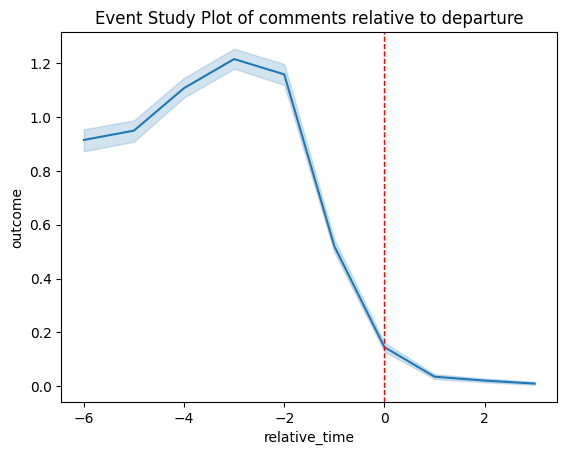

/tmp/user/20506/ipykernel_2538725/3767982912.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_panel['outcome'] = (df_panel[criteria_col]/df_panel[normalization_col]).fillna(0)


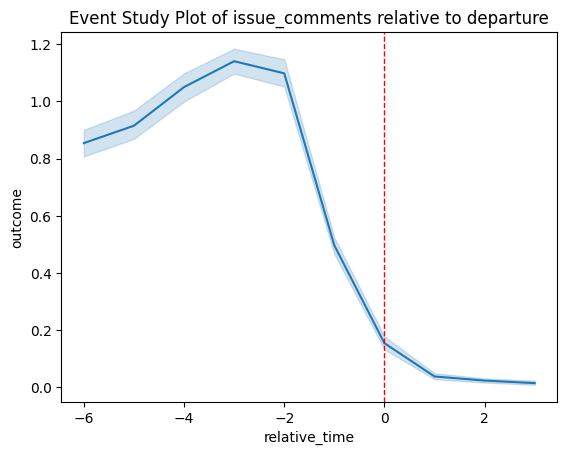

/tmp/user/20506/ipykernel_2538725/3767982912.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_panel['outcome'] = (df_panel[criteria_col]/df_panel[normalization_col]).fillna(0)


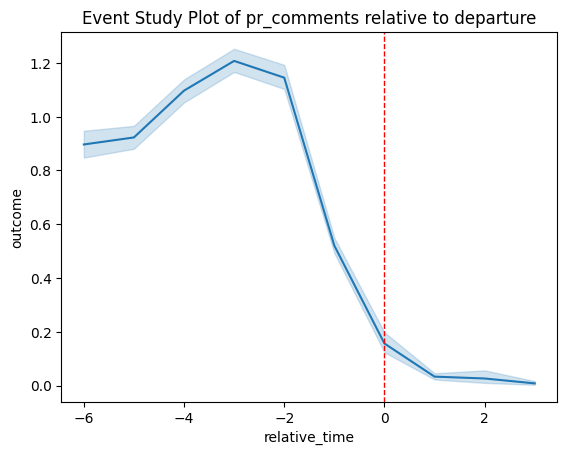

/tmp/user/20506/ipykernel_2538725/3767982912.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_panel['outcome'] = (df_panel[criteria_col]/df_panel[normalization_col]).fillna(0)


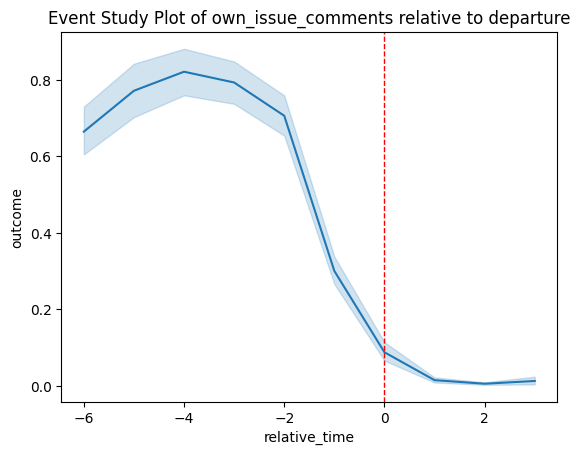

/tmp/user/20506/ipykernel_2538725/3767982912.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_panel['outcome'] = (df_panel[criteria_col]/df_panel[normalization_col]).fillna(0)


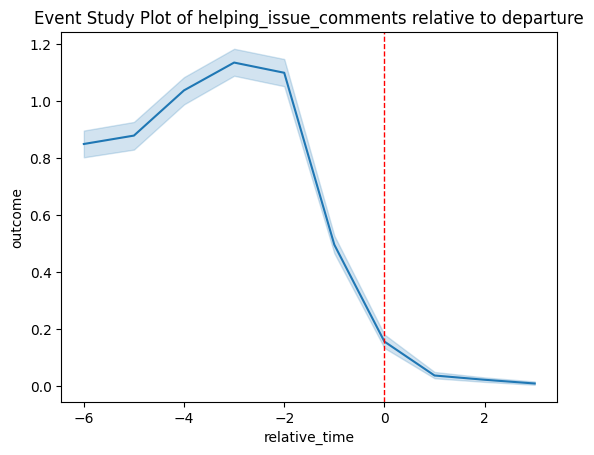

/tmp/user/20506/ipykernel_2538725/3767982912.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_panel['outcome'] = (df_panel[criteria_col]/df_panel[normalization_col]).fillna(0)


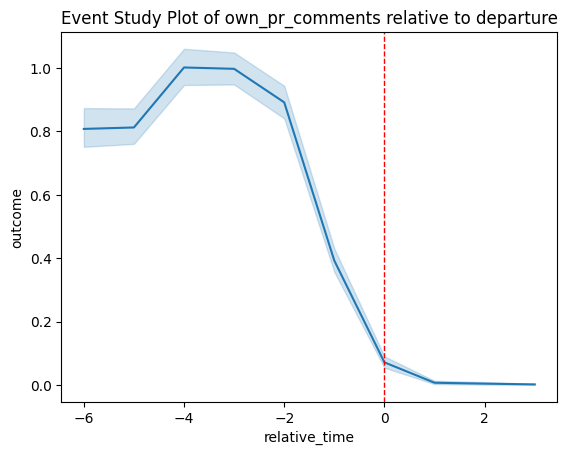

/tmp/user/20506/ipykernel_2538725/3767982912.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_panel['outcome'] = (df_panel[criteria_col]/df_panel[normalization_col]).fillna(0)


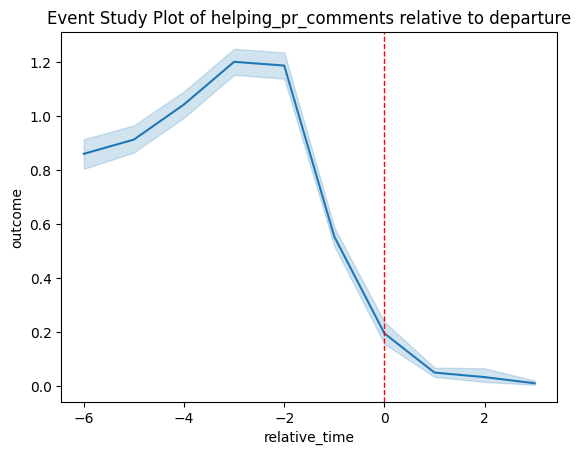

/tmp/user/20506/ipykernel_2538725/3767982912.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_panel['outcome'] = (df_panel[criteria_col]/df_panel[normalization_col]).fillna(0)


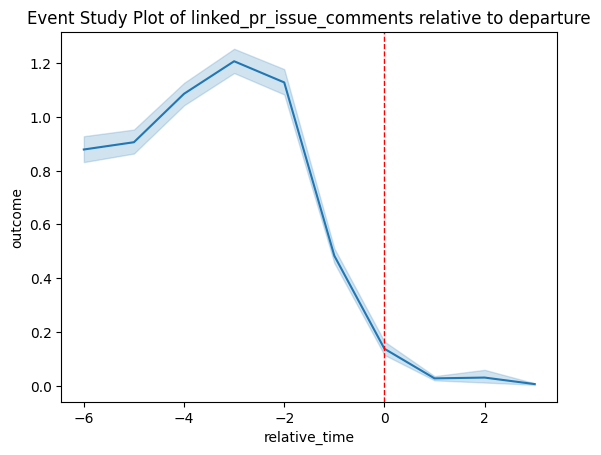

/tmp/user/20506/ipykernel_2538725/3767982912.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_panel['outcome'] = (df_panel[criteria_col]/df_panel[normalization_col]).fillna(0)


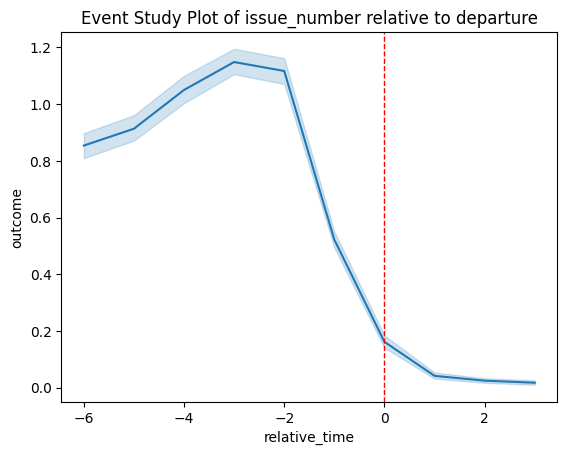

/tmp/user/20506/ipykernel_2538725/3767982912.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_panel['outcome'] = (df_panel[criteria_col]/df_panel[normalization_col]).fillna(0)


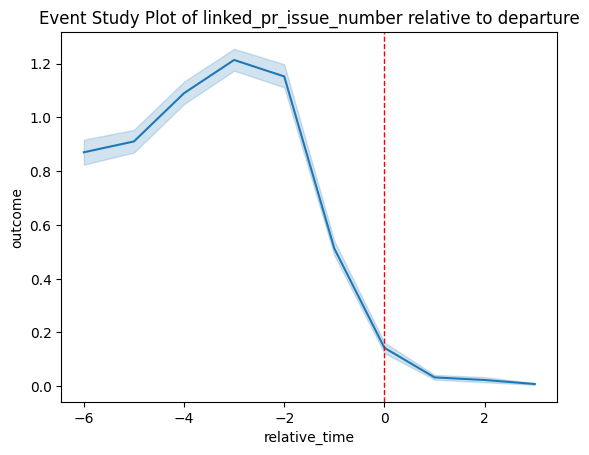

/tmp/user/20506/ipykernel_2538725/3767982912.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_panel['outcome'] = (df_panel[criteria_col]/df_panel[normalization_col]).fillna(0)


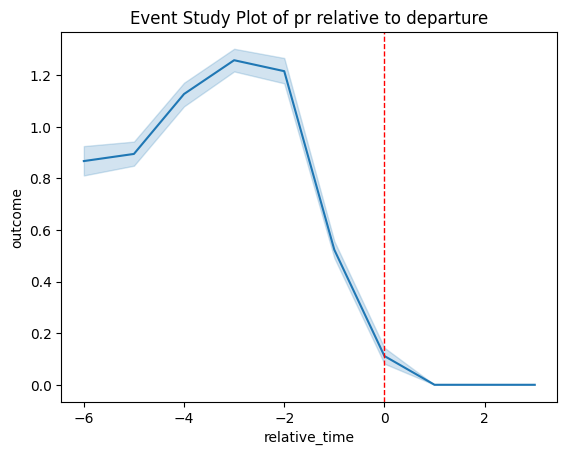

/tmp/user/20506/ipykernel_2538725/3767982912.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_panel['outcome'] = (df_panel[criteria_col]/df_panel[normalization_col]).fillna(0)


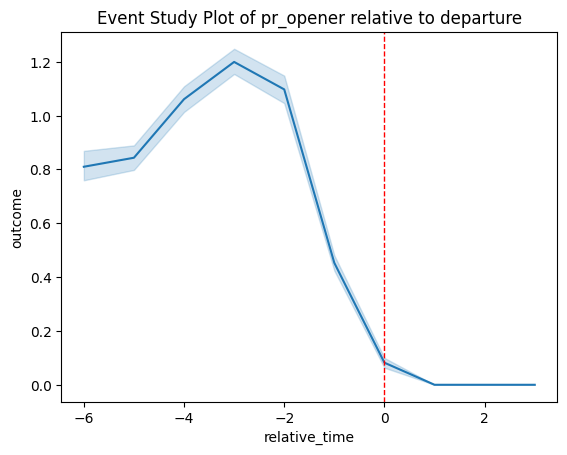

/tmp/user/20506/ipykernel_2538725/3767982912.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_panel['outcome'] = (df_panel[criteria_col]/df_panel[normalization_col]).fillna(0)


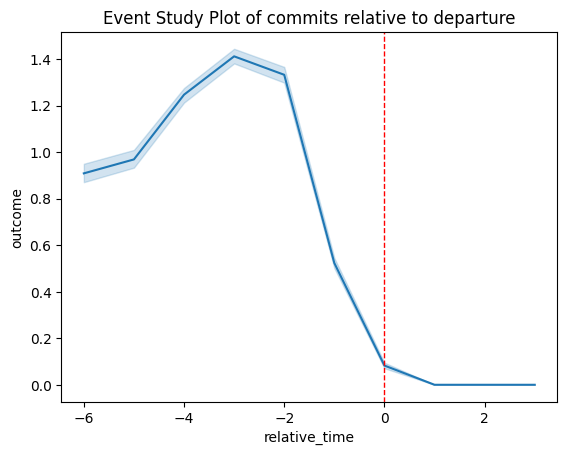

/tmp/user/20506/ipykernel_2538725/3767982912.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_panel['outcome'] = (df_panel[criteria_col]/df_panel[normalization_col]).fillna(0)


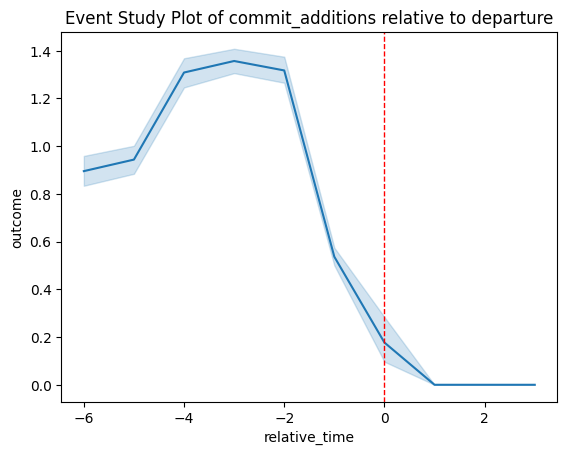

/tmp/user/20506/ipykernel_2538725/3767982912.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_panel['outcome'] = (df_panel[criteria_col]/df_panel[normalization_col]).fillna(0)


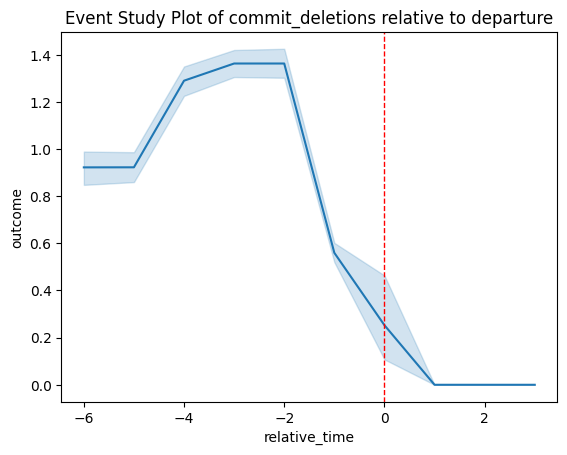

/tmp/user/20506/ipykernel_2538725/3767982912.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_panel['outcome'] = (df_panel[criteria_col]/df_panel[normalization_col]).fillna(0)


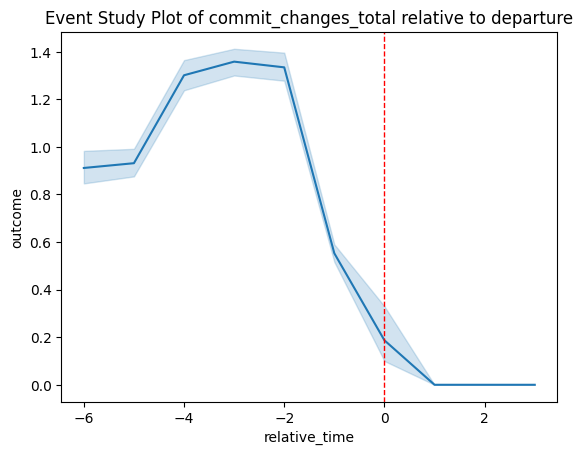

/tmp/user/20506/ipykernel_2538725/3767982912.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_panel['outcome'] = (df_panel[criteria_col]/df_panel[normalization_col]).fillna(0)


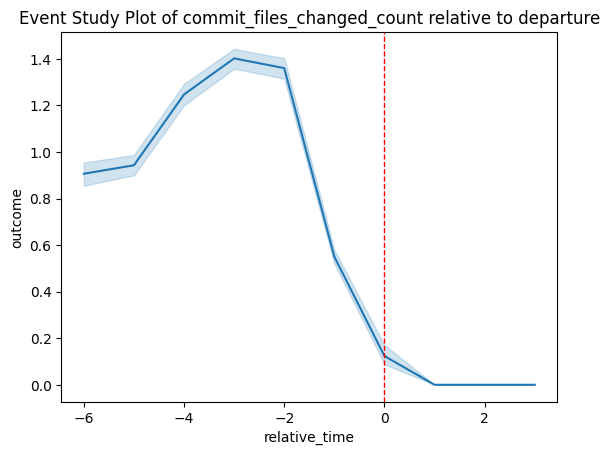

/tmp/user/20506/ipykernel_2538725/3767982912.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_panel['outcome'] = (df_panel[criteria_col]/df_panel[normalization_col]).fillna(0)


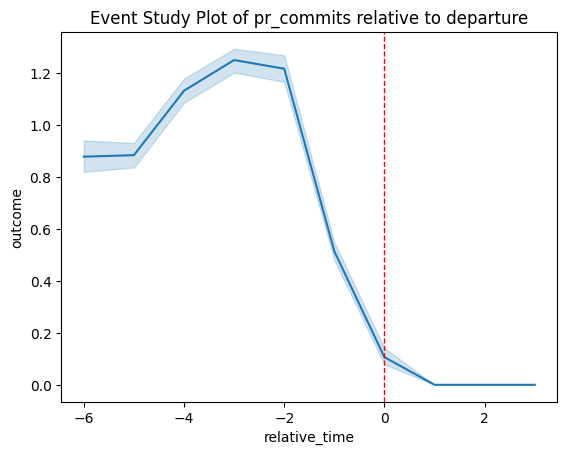

/tmp/user/20506/ipykernel_2538725/3767982912.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_panel['outcome'] = (df_panel[criteria_col]/df_panel[normalization_col]).fillna(0)


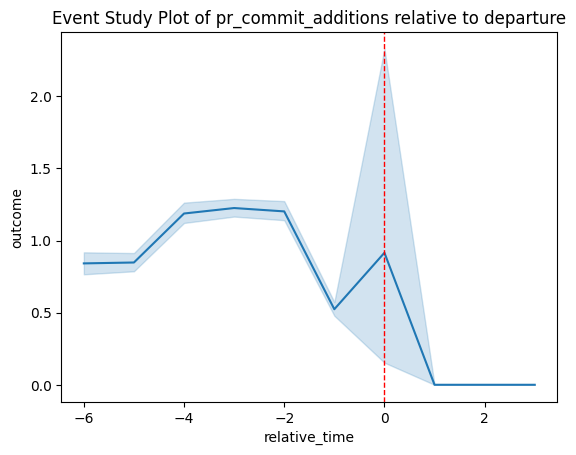

/tmp/user/20506/ipykernel_2538725/3767982912.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_panel['outcome'] = (df_panel[criteria_col]/df_panel[normalization_col]).fillna(0)


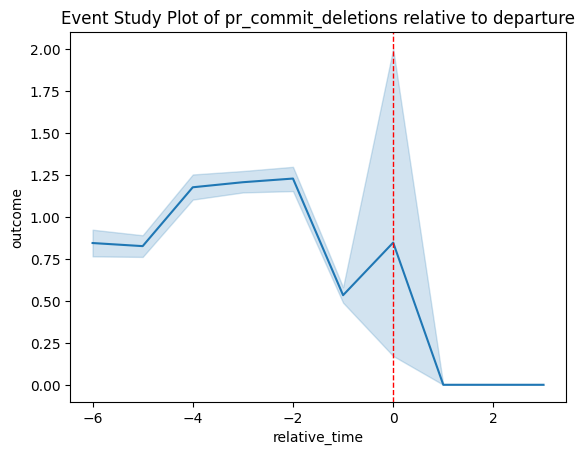

/tmp/user/20506/ipykernel_2538725/3767982912.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_panel['outcome'] = (df_panel[criteria_col]/df_panel[normalization_col]).fillna(0)


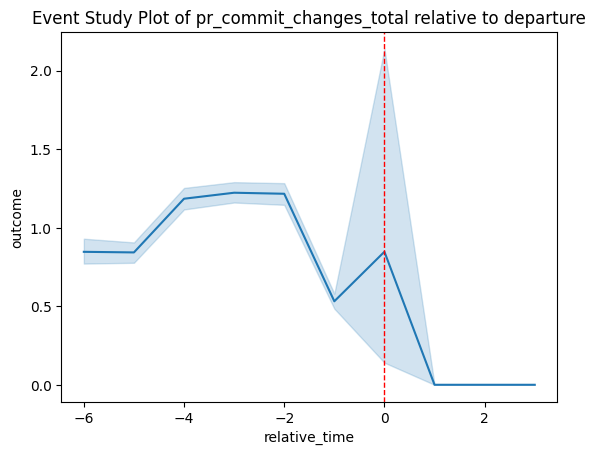

/tmp/user/20506/ipykernel_2538725/3767982912.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_panel['outcome'] = (df_panel[criteria_col]/df_panel[normalization_col]).fillna(0)


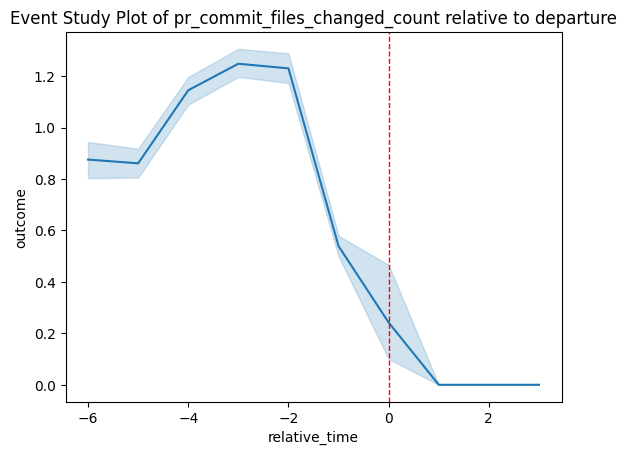

/tmp/user/20506/ipykernel_2538725/3767982912.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_panel['outcome'] = (df_panel[criteria_col]/df_panel[normalization_col]).fillna(0)


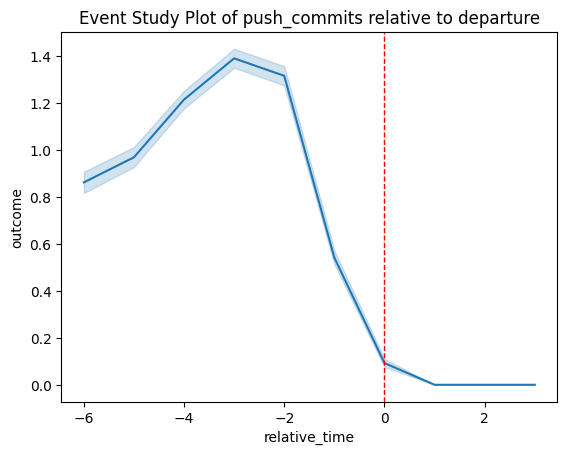

/tmp/user/20506/ipykernel_2538725/3767982912.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_panel['outcome'] = (df_panel[criteria_col]/df_panel[normalization_col]).fillna(0)


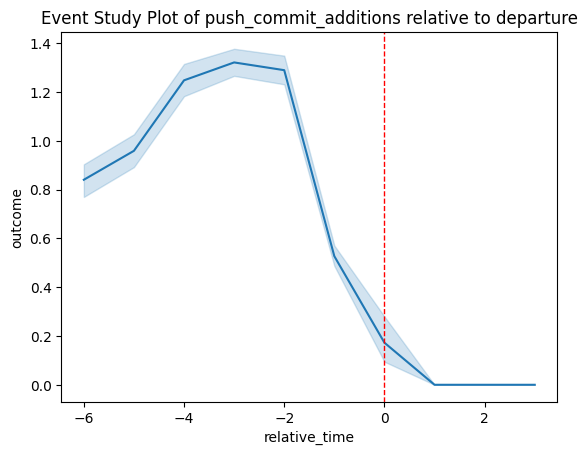

/tmp/user/20506/ipykernel_2538725/3767982912.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_panel['outcome'] = (df_panel[criteria_col]/df_panel[normalization_col]).fillna(0)


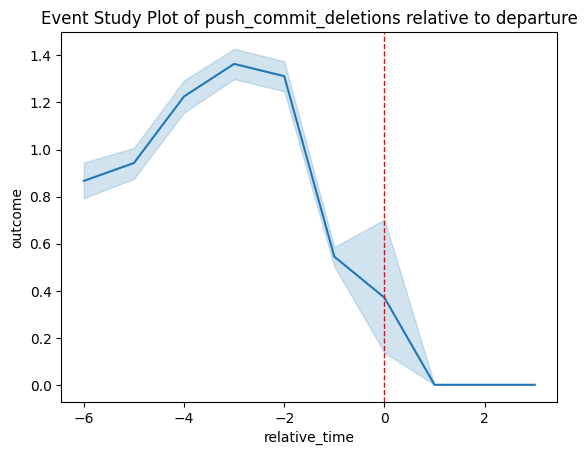

/tmp/user/20506/ipykernel_2538725/3767982912.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_panel['outcome'] = (df_panel[criteria_col]/df_panel[normalization_col]).fillna(0)


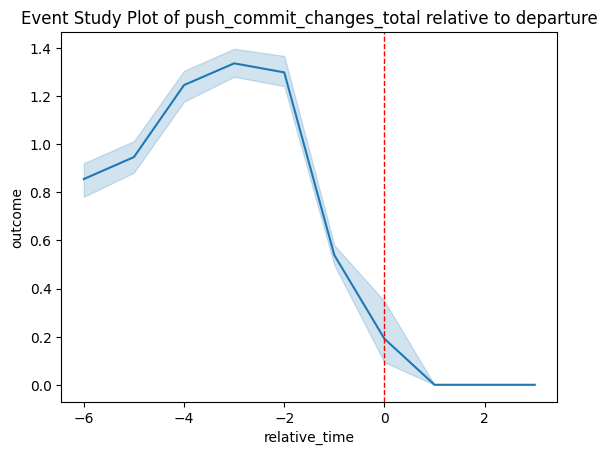

/tmp/user/20506/ipykernel_2538725/3767982912.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_panel['outcome'] = (df_panel[criteria_col]/df_panel[normalization_col]).fillna(0)


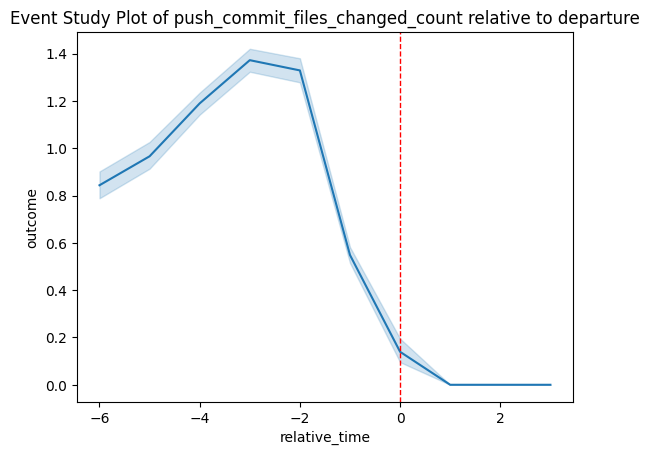

/tmp/user/20506/ipykernel_2538725/3767982912.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_panel['outcome'] = (df_panel[criteria_col]/df_panel[normalization_col]).fillna(0)


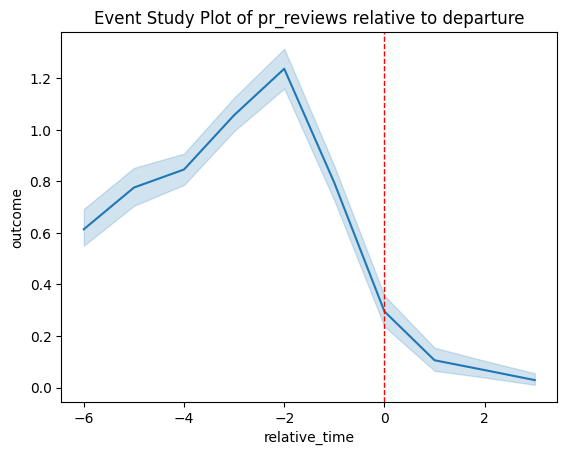

/tmp/user/20506/ipykernel_2538725/3767982912.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_panel['outcome'] = (df_panel[criteria_col]/df_panel[normalization_col]).fillna(0)


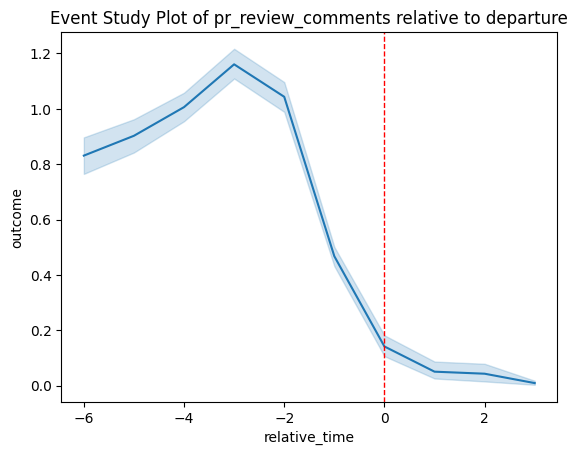

/tmp/user/20506/ipykernel_2538725/3767982912.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_panel['outcome'] = (df_panel[criteria_col]/df_panel[normalization_col]).fillna(0)


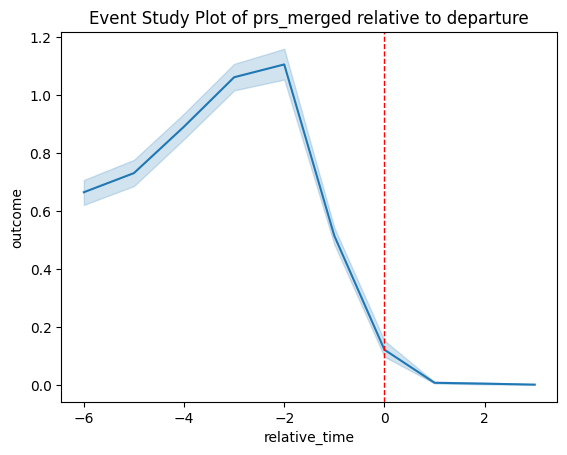

/tmp/user/20506/ipykernel_2538725/3767982912.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_panel['outcome'] = (df_panel[criteria_col]/df_panel[normalization_col]).fillna(0)


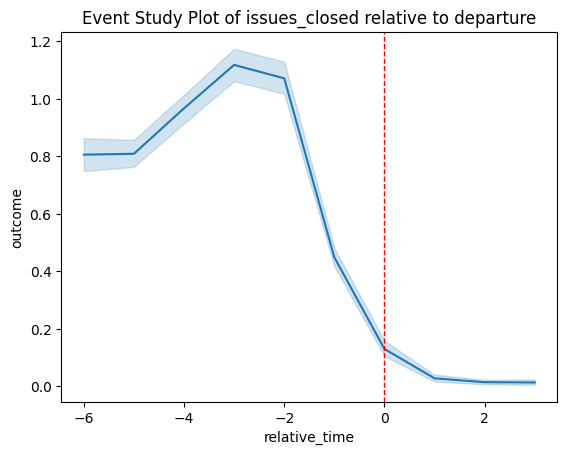

In [25]:
for val_col in val_cols:
    DepartureEventStudy(df_departed_histories, pre_period, post_period, val_col)

In [46]:
df_participated_post_departure = df_departed_histories.query(f'relative_time>=0')[val_cols+['repo_name','actor_id']]\
    .groupby(['repo_name','actor_id'])\
    .sum().sum(axis = 1).astype(bool).reset_index().rename({0:'participated_post_departure'}, axis = 1)

In [47]:
departure_validation_sorted = df_participated_post_departure.assign(manual_valid_departure='').sample(frac = 1, random_state = 3)
sorted_departures = pd.merge(departure_validation_sorted.drop('participated_post_departure', axis = 1), df_departed_histories)
departure_validation_sorted.to_csv('issue/departures.csv')

In [49]:
for t in np.arange(3):
    activity_count = df_departed_histories.query(f'relative_time>={t}')[val_cols+['repo_name','actor_id']]\
        .groupby(['repo_name','actor_id'])\
        .sum()
    
    indiv_activity_count = activity_count.sum(axis = 1)
    print("Prop of individuals with no activity in any category {} periods after departure: {:.2f}".format(t, np.mean(indiv_activity_count == 0)))
    print("Categories with most frequent infringements")
    print(activity_count.astype(bool).astype(int).mean().sort_values(ascending = False).head(5))
    print()

Prop of individuals with no activity in any category 0 periods after departure: 0.64
Categories with most frequent infringements
comments                    0.326036
issue_number                0.326036
issue_comments              0.257232
helping_issue_comments      0.240813
linked_pr_issue_comments    0.239640
dtype: float64

Prop of individuals with no activity in any category 1 periods after departure: 0.82
Categories with most frequent infringements
comments                    0.157936
issue_number                0.157936
issue_comments              0.120407
linked_pr_issue_comments    0.112588
linked_pr_issue_number      0.112588
dtype: float64

Prop of individuals with no activity in any category 2 periods after departure: 0.85
Categories with most frequent infringements
comments                    0.135822
issue_number                0.135822
issue_comments              0.105754
helping_issue_comments      0.097460
linked_pr_issue_comments    0.092794
dtype: float64

